## **Soft Set MSER**
A slight modification over [maximally stable extermal region (MSER)](https://ieeexplore.ieee.org/abstract/document/6977248) through simple machine learning theory.

### ***Step1: Import the necessary packages***

In [1]:
from PIL import Image
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pandas as pd
from numba import jit, cuda
import cv2
from google.colab.patches import cv2_imshow

### ***Step2: Initialization***
*Initialize two empty list to store the inverse and normalize components.*

In [2]:
inv_component=[]
norm_component=[]

### ***Step3: Find area***
*We use adaptive thresholding and connected component strategy.*

In [3]:
def Find_area(key,j):
  #ret, thresh = cv2.threshold(img, j, 255, cv2.THRESH_BINARY_INV)
  thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, j, 5)
  connectivity = 8

  output = cv2.connectedComponentsWithStats(thresh2, connectivity, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  area = stats[key, cv2.CC_STAT_AREA]
  return area

### ***Step4: Auxiliary Functions***
*A basic function to measure the frequency of an element in a list.*

In [4]:
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

### ***Step 5: The main contribution***
*Here, we creating two soft-set and computing the diferences between them.*

In [5]:
centa={}
#Compute Difference between two soft set.
def difference(Soft1,Soft2,t1,t2):
    p={}
    x=[v for k,v in Soft1.items()]
    y=[v for k,v in Soft2.items()]
    key1=[]
    key2=[]
    for k,v in Soft1.items():

            sp1=k.split("=")[1]
            tp1=sp1.split(",")
            Cx=tp1[0]
            Cy=tp1[1]

            key1.append((Cx,Cy))

    for k,v in Soft2.items():

            sp2=k.split("=")[1]
            tp2=sp2.split(",")
            Cx=tp2[0]
            Cy=tp2[1]

            key2.append((Cx,Cy))

    if(len(x)>len(y)):
          for dp in key1:
              if dp not in key2:
                    key1.remove(dp)
    elif(len(x)<len(y)):
          for dp in key2:
              if dp not in key1:
                    key2.remove(dp)

    x_e=[]
    y_e=[]
    for k,v in Soft1.items():

            sp1=k.split("=")[1]
            tp1=sp1.split(",")
            Cx=tp1[0]
            Cy=tp1[1]
            if (Cx,Cy) in key1:
                x_e.append(((Cx,Cy),int(v)))
    for k,v in Soft2.items():

            sp1=k.split("=")[1]
            tp1=sp1.split(",")
            Cx=tp1[0]
            Cy=tp1[1]
            if (Cx,Cy) in key2:
                y_e.append(((Cx,Cy),int(v)))

    Y_e={}
    for k in range(len(y_e)):
        cent=y_e[k][0]
        val=y_e[k][1]
        Y_e[cent]=val
    prev=set(x_e)
    curr=set(y_e)



    s=str(t1)+"-"+str(t2)
    s_c=[]
    for i in range(len(x_e)):
         q_x=x_e[i][0]

         size_q_x=x_e[i][1]
         if q_x in Y_e.keys():
              d=size_q_x - Y_e[q_x]
              #print(s,d)
              s_c.append((q_x,d))



    centa[s]=s_c

### ***Step6: Create Information Matrix***


In [6]:
def Info_mat(img):
    data={}

    for j in range(41,100,2):
        label_set={}

        thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, j, 5)
        #ret, thresh = cv2.threshold(img, j, 255, cv2.THRESH_BINARY_INV)
        #print("For t=", j)
        thresh = (thresh2 > 0).astype(np.uint8)
        connectivity = 8
        output = cv2.connectedComponentsWithStats(thresh2, connectivity, cv2.CV_32S)
        (numLabels, labels, stats, centroids) = output

        for i in range(0,numLabels):
          area = stats[i, cv2.CC_STAT_AREA]
          (cX, cY) = centroids[i]
          #print("size--->",out)
          st=str(i)+"="+str(int(cX))+","+str(int(cY))
          label_set[st]=Find_area(i,j)
        data[j]=label_set
    return data

*Let's test something!!!*

In [7]:
img1 = cv2.imread("/content/0069184.jpg")
img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
data=Info_mat(img)

In [8]:
keys_set=[k for k in data.keys()]
set1=[]
for i in range(len(keys_set)-1):
    t1=keys_set[i]
    t2=keys_set[i+1]
    difference(data[t1],data[t2],t1,t2)


In [9]:
def Count_zero(l):
    count=0
    for i in range(len(l)):
        k=l[i]
        if(k[1]==0):
            count=count+1
    return count

In [10]:
zero_count={}
len_count={}
for k,v in centa.items():
    c=Count_zero(v)
    sp=len(v)
    len_count[k]=sp
    zero_count[k]=c

*Lots of cool stuff!!! isn't it?*😁


*What we did is basically very easy. We perform adaptive thresholding with various block size in the range of (41-100) and computer the difference between two instances. Then we make a count we  differences are zero so that we can remove it later. The non-zero instances is going to be our soft-set for the image.*

### ***Step 7: Create Component Marking***

In [11]:
def Component_marking(th):
    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, th, 5)
    #ret, thresh=cv2.threshold(img,th,255,cv2.THRESH_BINARY)
    thresh = (thresh2 > 0).astype(np.uint8)
    connectivity=8
    output = cv2.connectedComponentsWithStats(thresh2, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    output = img1.copy()
    k=255
    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        (cX, cY) = centroids[i]

        if(area > 20 ):
             (cX, cY) = centroids[i]
             norm_component.append(((cX,cY),area))
             cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
             #cv2.circle(output, (int(cX), int(cY)), 4, (s, 0, k), -1)
             componentMask = (labels == i).astype("uint8") * 255
             # show our output image and connected component mask
             #cv2_imshow(output)
             #print(componentMask)
             #cv2.imshow("Connected Component", componentMask)
             output=output.copy()
             k=k-50
    cv2_imshow(output)
    return output

### ***Step 8: Inverse Component Marking***

In [12]:
def Component_marking_inv(th):
    I=Component_marking(th)
    thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, th, 5)
    #ret,thresh=cv2.threshold(img,th,255,cv2.THRESH_BINARY_INV)
    thresh = (thresh2 > 0).astype(np.uint8)
    connectivity=8
    output = cv2.connectedComponentsWithStats(thresh2, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    output = I.copy()
    k=255
    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        if(area >20  ):

             inv_component.append(((cX,cY),area))
             cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
             #cv2.circle(output, (int(cX), int(cY)), 4, (s, 0, k), -1)
             componentMask = (labels == i).astype("uint8") * 255
             # show our output image and connected component mask
             #cv2_imshow(output)
             #print(componentMask)
             #cv2.imshow("Connected Component", componentMask)
             output=output.copy()
             k=k-50

    cv2_imshow(output)
    return (output)

*Time for some computation!!!*

In [13]:
all_values = zero_count. values()
max_value = int(sum(all_values) / len(all_values))
component=len_count.values()
avg=int(sum(component)/len(component))

*This is how the component marking looks like!!!*😊

Threshold----> 51


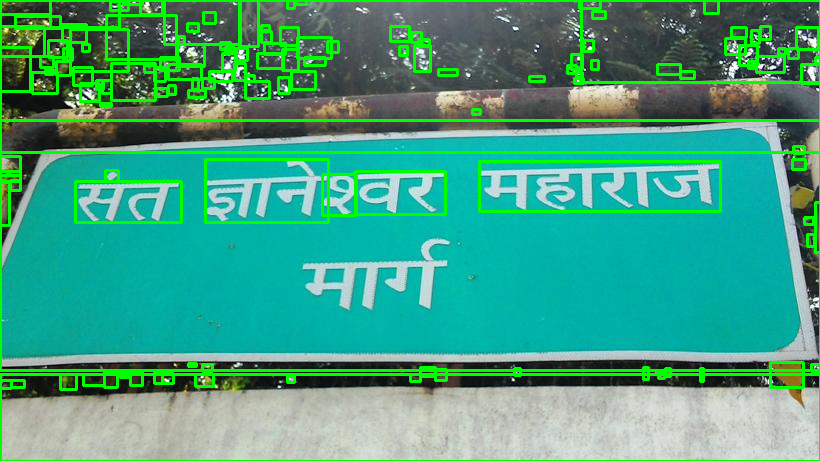

In [14]:
for k,v in zero_count.items():
      st=k.split("-")
      if(v<=max_value+4 and v>=max_value-4):

            print("Threshold---->",st[0])
            Component_marking(int(st[0]))
            break
threshold = st[0]

*This is how inverse component marking looks like!!!*😊

Threshold----> 51


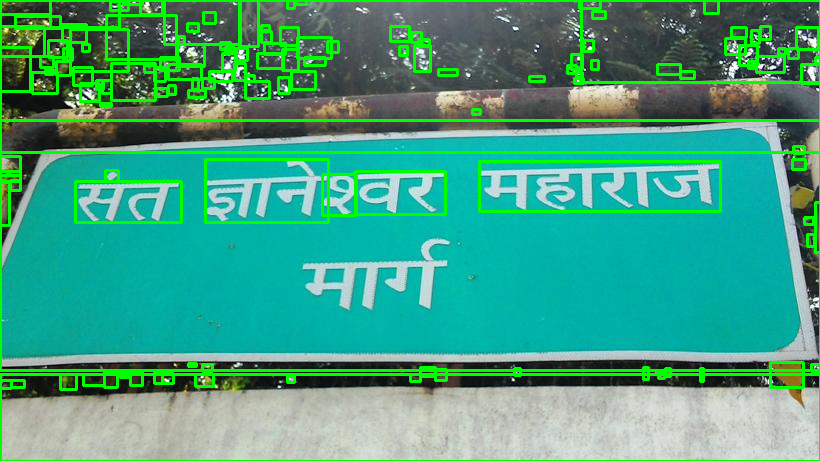

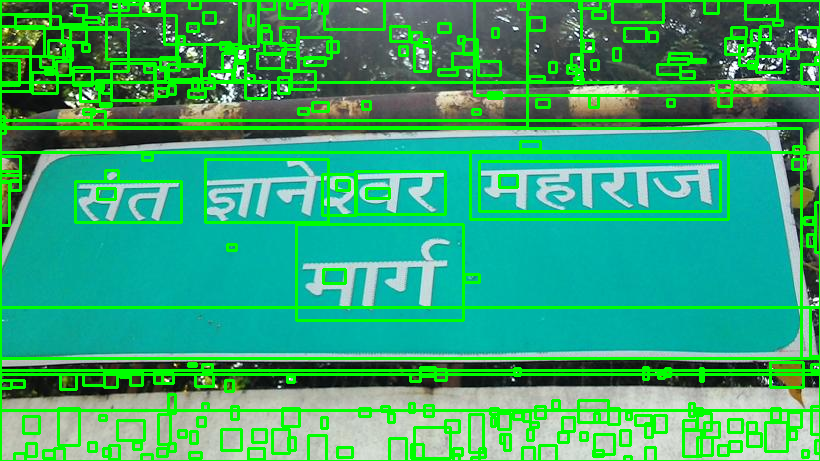

In [15]:
for k,v in zero_count.items():
      st=k.split("-")
      if(v<=max_value+4 and v>=max_value-4):

            print("Threshold---->",st[0])
            Component_marking_inv(int(st[0]))
            break
threshold = st[0]

*Now the questions is which one we should use and why???*🤔

*Its a surprise!!!*😂

*We wil reveal it in the next cell!!!*😉

### ***Final Step: The Softset Function***

In [16]:
def softset(img):
    data=Info_mat(img)
    keys_set=[k for k in data.keys()]
    set1=[]
    for i in range(len(keys_set)-1):
        t1=keys_set[i]
        t2=keys_set[i+1]
        difference(data[t1],data[t2],t1,t2)
    zero_count={}
    len_count={}
    for k,v in centa.items():
        c=Count_zero(v)
        sp=len(v)
        len_count[k]=sp
        zero_count[k]=c
    #print(zero_count)
    all_values = zero_count. values()
    max_value = int(sum(all_values) / len(all_values))
    component=len_count.values()
    avg=int(sum(component)/len(component))
    for k,v in zero_count.items():
        st=k.split("-")
        if(v<=max_value+4 and v>=max_value-4):
            #print("Threshold---->",st[0])
            output = Component_marking_inv(int(st[0]))
            break
            cv2.imwrite("/content/0069184_out.jpg",output)
    threshold = st[0]

### ***Softset visualization***

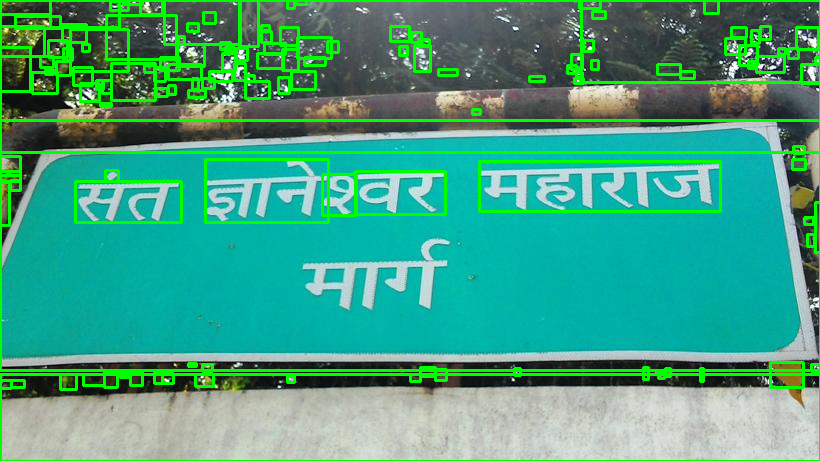

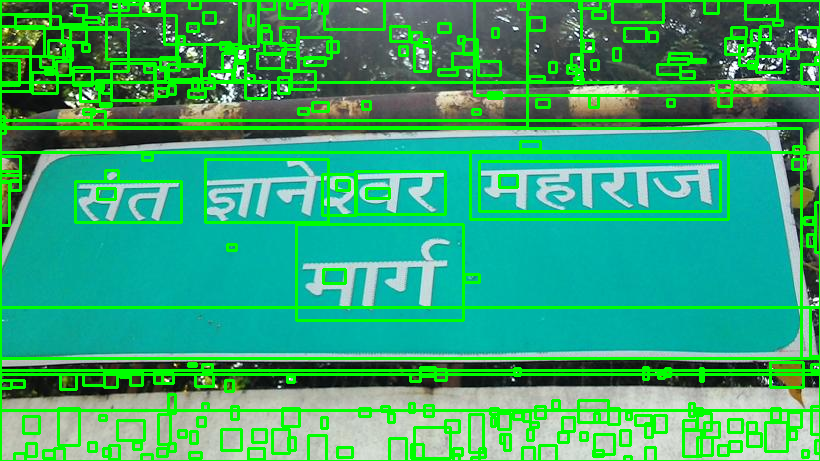

In [17]:
softset(img)

### ***SoftSet-MSER Visualization***

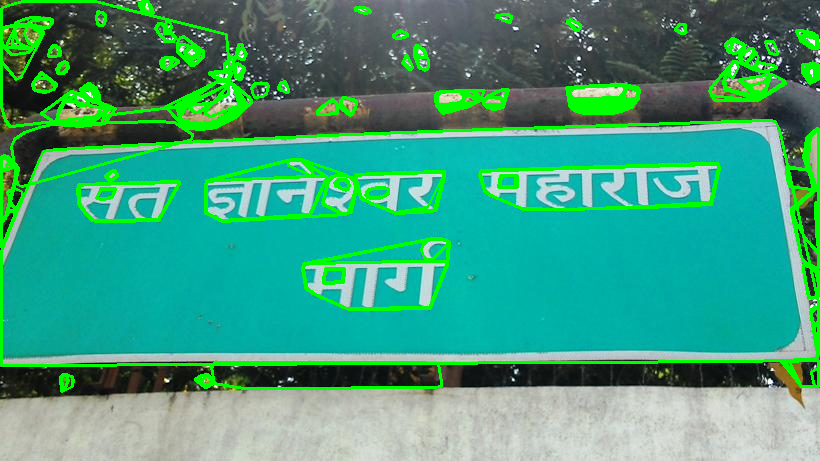

In [18]:
mser = cv2.MSER_create()
vis = img1.copy()

#detect regions in gray scale image
regions, _ = mser.detectRegions(img)

hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

cv2.polylines(vis, hulls, 1, (0, 255, 0), 2)

cv2_imshow(vis)